In [1]:
import fermat as F
import numpy as np
import scipy.sparse as sp
import time
from scipy.spatial import  distance_matrix
from sklearn.manifold import TSNE
from scipy.optimize import minimize
from sklearn.neighbors import KDTree
from scipy.optimize import LinearConstraint
from scipy.sparse import csr_matrix


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

importe lo necesario y armo las funciones que me dicen el costo de transportar una serie de puntos con fermat dada la matriz de distancias de fermat (lo que usaba en transporte optimo antes), tambien hago su gradiente y pruebo

In [2]:
#Builds fermat graph given data, alpha, method (and if 'D' is chosen with k_fermat neighbours)
#RETURNS: fermat distance matrix between points of data and a KD-Tree 


def fermat_graph(data,alpha,method='FW',k_fermat=30):
    model=F.Fermat(alpha, path_method=method,k=k_fermat)
    model.fit(np.matrix(distance_matrix(data,data)))
    fermat_distances = model.get_distances()
    tree = KDTree(data, leaf_size=2)
    return fermat_distances,tree
              

#Computes fermat_cost of transporting initialData to x with the given fermat_distances
#initial data will be points

#It uses the KD-Tree built with fermat_graph() as well as a parameter 'k' which is 
#the amount of neighbours to look at when getting the fermat distance for a point that
#is not in the graph (including it may be computationally expensive)
#It also recieves the original data and the alpha used to build fermat_distances
              
#RETURNS: fermat cost and gradient of that cost
def fermat_cost(x,initialData,dimension,fermat_distances,tree,data,k,alpha):
    assert(len(x)==(initialData.shape[0])*dimension)
    real_x=x.reshape(-1,dimension)     
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        dist,grad_idx=fermat_dist(initialData[i,:],real_x[i,:],fermat_distances,tree,k,alpha) 
        q=data[grad_idx,:] 
        local_grad=alpha*(np.linalg.norm(q-real_x[i,:])**(alpha-2))*(real_x[i,:]-q)
        
        res+=dist                      
        gradient[dimension*i:dimension*(i+1)]=local_grad
    return res,gradient


#Computes fermat distance between start  and end using fermat_distances
              
#it also recieves the KD-tree, numbre of neighbours to look at, and alpha used in fermat
              
#RETURNS: fermat distance between start and end, as well as the index of the k-nearest neighbour
#of end with smallest fermat distance to start
def fermat_dist(start,end,fermat_distances,tree,k,alpha):
    
    start_euclid_dist,start_ind=tree.query([start],k=1)
    idx=start_ind[0,0]
    start_euclid_dist=np.power(start_euclid_dist,alpha)
    
    end_euclid_dist,end_ind=tree.query([end],k=k)
    end_euclid_dist=np.power(end_euclid_dist,alpha)
        
    dist=min([ fermat_distances[idx,end_ind[0,i]]+end_euclid_dist[0,i] for i in range(end_euclid_dist.shape[1])])
    
    minim=np.argmin([ fermat_distances[idx,end_ind[0,i]] for i in range(end_ind.shape[1])]) 
    grad_idx=end_ind[0,minim] #index of k-nearest neighbour with smallest fermat_distance to idx.
    
    return dist+start_euclid_dist[0,0],grad_idx
              

#Here initialData are the points, and x the trasnportation of those
##UNUSED
def euclidean_cost(x,initialData):
    dim=initialData.shape[1]
    assert(initialData.shape[0]*dim==len(x))
    real_x=x.reshape(-1,dim)
    res=0
    gradient=np.zeros(x.shape)
    for i in range(initialData.shape[0]):
        res+=np.linalg.norm(initialData[i,:]-real_x[i,:])**2
        local_gradient=2*(real_x[i,:]-initialData[i,:])
        gradient[dim*i:(i+1)*dim]=local_gradient
    return res,gradient


un ejemplito

In [3]:
data=np.random.random((10,2))

x=np.ones(16)

##Euclidean
print(euclidean_cost(x,data[0:8,:]))

##Fermat

initialData=data[0:8,:]
dimension=2
alpha=2
k=2
f_dist,tree=fermat_graph(data,alpha=alpha)


fermat_cost(x,initialData,dimension,f_dist,tree,data,k,alpha)

(4.4067790069601935, array([0.2282604 , 0.70131191, 0.72184658, 0.10649595, 1.14685128,
       1.28628348, 0.06035604, 0.854658  , 1.7956379 , 0.07368768,
       0.37101101, 0.79991971, 1.95368041, 0.80888865, 1.70888595,
       1.20339915]))


(1.936371602670885,
 array([0.2282604 , 0.70131191, 0.72184658, 0.10649595, 0.2282604 ,
        0.70131191, 0.2282604 , 0.70131191, 0.72184658, 0.10649595,
        0.2282604 , 0.70131191, 0.72184658, 0.10649595, 0.72184658,
        0.10649595]))

Armo aca los datos que podrian servir para al menos probar que ande

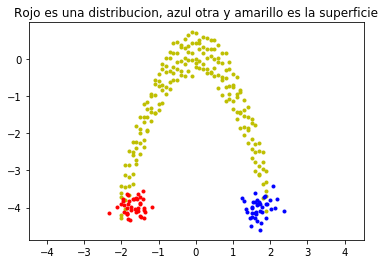

In [4]:
puntos=40

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1)
W=np.concatenate((x,y),axis=1)


dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.5
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) -0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)

dx=4/puntos
x=np.array([-2+i*dx for i in range(puntos)]).reshape(-1,1)
y=-x*x.reshape(-1,1) +0.3*np.random.random(puntos).reshape(-1,1) +0.25
W=np.concatenate((W,np.concatenate((x,y),axis=1)),axis=0)




y1, y2 = np.random.multivariate_normal([1.7,-4], [[0.05,0],[0,0.05]], puntos).T
y1=np.array(y1)
y2=np.array(y2)
y1=y1.reshape(-1,1)
y2=y2.reshape(-1,1)

Ycol=np.concatenate((y1,y2),axis=1)
Y=Ycol.flatten()


x1, x2 = np.random.multivariate_normal([-1.7,-4], [[0.05,0],[0,0.05]], puntos).T
x1=np.array(x1)
x2=np.array(x2)
x1=x1.reshape(-1,1)
x2=x2.reshape(-1,1)
Zcol=np.concatenate((x1,x2),axis=1)
Z=Zcol.flatten()





plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie')
plt.show()

# ACA ARRANCA LO NUEVO

## Tomo la dist de fermat al cuadrado por lo que dijo esteban, sino cualquier solucion en la geodesica va a ser lo mismo

In [24]:
data=np.concatenate((Zcol,Ycol,W),axis=0)


x=np.concatenate((Zcol,Ycol),axis=0) #los datos X iniciales, las distribuciones. 
z=np.matrix([0 for i in range(Zcol.shape[0])]+[1 for i in range(Ycol.shape[0])]).T
#le pongo label 0 a la primera y 1 a la segunda




alpha=2
k=40
dimension=2
h=np.std(x)*1.06*(x.shape[0]**(-1/5)) #TODO (es el bandwith de los kernel)
f_dist,tree=fermat_graph(data,alpha=alpha)
f_dist=f_dist#**2

#PUSE EL CUADRADO PERO NO CAMBIE EL GRADIENTE!
#(HABRIA QUE REESCALARLO CON UN 2*DIST_FERMAT),NO? TODO


### Defino las funciones que utilizan en el paper de tabak. Basicamente los nucleos y sus gradientes (armo una matriz que tiene el resultado de los kernel con los posibles centros evaluados en  los posibles puntos), esta matriz C que definen, el lagrangiano y su gradiente 

In [25]:
#ARMO LA MATRIZ C    
#vector con los valores z que hay, una matriz por filas paso
#viene en el mismo orden que los y
def armar_C(z,b=1):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=kernel(z[j],z[i],b,1)
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C

def armar_C_categorico(z):
    z_matrix=np.zeros((z.shape[0],z.shape[0]))
    for j in range(z.shape[0]):
        sumita=0
        for i in range (z.shape[0]):
            aux=0
            if(z[i]==z[j]):
                aux=1
            z_matrix[i,j]=aux
            sumita+=aux
        z_matrix[:,j]=z_matrix[:,j]/sumita
    C=z_matrix-np.mean(z_matrix,axis=0).reshape(-1,1)
    return C





#DEFINO LOS KERNEL Y SUS GRADIENTES (DERIVO EN PRIMER COORDENADA)
def kernel2(x,centro):
    return np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 
     
def kernel_grad2(x,centro):
    return -(1/(h**2))*(x-centro)*np.exp( -np.linalg.norm(x-centro)**2/(2*(h**2)) )/np.sqrt((2*np.pi)**dimension) 




#matriz que tieneen el lugar ij al kernel(y_i,y_j) y
#lo mismo con gradiente_ij (en la primer coord derivo el kernel de centro y_j y evaluo en y_i)
#TENGO QUE HACERLO MAS RAPIDO ESTO!!
def kernel_matrix_y2(y):
        y_matrix=np.zeros((y.shape[0],y.shape[0]))
        for i in range(y.shape[0]):
            y_matrix[i,:]=np.array([kernel2(y[i,:],y[j,:])  for j in range(y.shape[0])]).reshape(1,-1)
        return y_matrix
    
def grad_matrix_y2(y):
        grad_matrix=np.zeros((y.shape[0],y.shape[0],dimension))
        for i in range(y.shape[0]):
            for j in range(y.shape[0]):
                grad_matrix[i,j,:]=kernel_grad2(y[i,:],y[j,:])
        return grad_matrix
                
        
        
        
        
#AHORA DEFINO LAGRANGIANO Y SU GRADIENTE                
def lagrangiano(landa,kernel_matrix,C,cost): 
    return  cost+ landa * (kernel_matrix.flatten() @ C.flatten())
#el lagrangiano es: sum_i[ cost(x_i,y_i)+ sum_k[landa*kernel(y_i,y_k)*C_il]   ]
    
    
    
    
    
#el gradiente de la parte de la F del lagrangiano
def fgrad(y,grad_matrix,C): 
    dimension=y.shape[1]
    aux=np.zeros(y.shape).flatten()
    for i in range (y.shape[0]):
        local_grad=C[i,:]@grad_matrix[i,:,:]
        aux[i*dimension:(i+1)*dimension]= local_grad
    return aux




# derivo en y_i
def lagrangiano_grad(landa,cost_grad,f_grad):
    return cost_grad+landa*f_grad






#La cuenta de como actualizar el landamin,hace la cuenta de que desciendo en direccion de L_F (que aca llamo f_grad)
def landamin_actualizacion(cost_grad,f_grad):
    num=cost_grad@f_grad
    denom=f_grad@f_grad
    return num/denom

### Tratando de paralelizar asi no es una tortuga (lo hago principalmente con lo de los kernels y su gradiente que es una cuenta que hago mucho y grande)

In [26]:
import scipy
from scipy.spatial.distance import pdist, squareform

#matriz que tieneen el lugar ij al kernel(y_i,y_j) 
def kernel_matrix_y(y):
    pairwise_dists = squareform(pdist(y, 'euclidean'))
    return scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension) )
    
    

    
def grad_matrix_y(y):
    pairwise_dists=squareform(pdist(y,'euclidean'))
    #armo la matriz que tiene el escalar por el que multiplico a la direccion
    aux=scipy.exp( -pairwise_dists**2/(2*(h**2))) / (np.sqrt( (2*np.pi)**dimension))
    aux=aux*(-1/(h**2))
    
    #simplemente hago en cada coordenada (De las d dimensiones) la resta de los y correspondeintes
    #en el lugar ij tendre y_i-y_j y eso luego lo multiplico por aux.
    unos=np.ones((y.shape[0],1))
    res=np.zeros((y.shape[0],y.shape[0],dimension))
    for d in range(dimension):
        res[:,:,d]=(y[:,d].reshape(-1,1)) @unos.T -  unos @ (y[:,d].reshape(-1,1)).T  
        res[:,:,d]=res[:,:,d]*aux
    return res
       

In [27]:
%%time
y=np.random.random((100,dimension))
asd=kernel_matrix_y(y)
asdd=grad_matrix_y(y)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 18 ms


In [28]:
%%time 
#VEMOS QUE ESTE TARDA MUCHO MAS, AHORA ES MAS EFICIENTE


asd2=kernel_matrix_y2(y)
asdd2=grad_matrix_y2(y)

CPU times: user 4.56 s, sys: 108 ms, total: 4.67 s
Wall time: 4.56 s


In [29]:
#CHEQUEO QUE EFECTIVAMENTE DE LO MISMO...
print(np.alltrue(asd2-asd<1e19),np.alltrue(asdd2-asdd<1e19))


True True


### El algoritmo que proponen (falta poner bien la formula del landamin que no la hice aun, ver que seria un buen beta y un buen landamax -ademas de una learningrate inicial y un h (el bandwith) inicial-)

In [35]:
#x va a ser los puntos iniciales (distintas distribuciones)
#y van a ser los transportados (baricentro)


niter=1000
learningrate0=1 #TODO 
beta=1  #es el alpha que pone tabak #TODO
landamax=10e4 #TODO
landa0=10#TODO


#y=np.ones(x.shape)
y=x
C=armar_C_categorico(z) #en z pongo fila a fila los distintos valores de z
landa=landa0
learningrate=learningrate0
n=0

while (n<niter):
    learningrate=min(learningrate*2.01,learningrate0)
    
    cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
    #cost,cost_grad=euclidean_cost(y.flatten(),x)
    
    
    grad_matrix=grad_matrix_y(y)
    f_grad=fgrad(y,grad_matrix,C)
    
    kernel_matrix=kernel_matrix_y(y)
    print(cost,(lagrangiano(landa,kernel_matrix,C,cost)-cost)/landa)
    
    
    beta=landa*0.2
    landamin=beta-landamin_actualizacion(cost_grad,f_grad)
    
    
    
    if(landamin>landa and landamin<landamax): 
        landa=landamin
    elif(landamin>landamax): 
        landa=landamax
    
    
    gradienteLagrangiano=lagrangiano_grad(landa,cost_grad,f_grad)
    yviejo=y
    costviejo=cost
    
    
    while(True):
        y=(yviejo.flatten()-(learningrate*gradienteLagrangiano)).reshape(yviejo.shape)  
        kernel_matrix=kernel_matrix_y(y) 
        
        cost,cost_grad=fermat_cost(y.flatten(),x,dimension,f_dist,tree,data,k,alpha)
        #cost,cost_grad=euclidean_cost(y.flatten(),x)
       
        lag_nuevo=lagrangiano(landa,kernel_matrix,C,cost)
        lag_viejo=lagrangiano(landa,kernel_matrix,C,costviejo)
        
        if(lag_nuevo<=(1+10/landa)*lag_viejo): 
            break #es que el lagrangiano nuevo disminuyo efectivamente (uso el y nuevo en ambos -kernel_matrix- pero el costo que a cada uno le corresponde)
        learningrate=learningrate/2             
      
    print("it: "+str(n)+", paso: "+str(learningrate*np.linalg.norm(gradienteLagrangiano))+", landa: "+str(landa))
    n=n+1       

0.0 5.747877331670478
it: 0, paso: 1.8591246406540998, landa: 10
3.0710729514238584 4.943590605259933
it: 1, paso: 0.6058827329173868, landa: 17.519614242971137
4.373176208419912 4.706009813167623
it: 2, paso: 0.8950907756501928, landa: 22.20677552891129
7.867579757599723 4.266073966510472
it: 3, paso: 1.2003147776969958, landa: 29.693706558633963
13.609006882764533 3.6848776075135175
it: 4, paso: 1.609521450617999, landa: 39.8559267920645
24.61637594044497 2.9124697745987436
it: 5, paso: 2.2573606273307405, landa: 55.729607337269414
44.272960620403445 1.9853019501295863
it: 6, paso: 1.7137577849296135, landa: 84.94256171378005
57.07405584016732 1.5003156890377707
it: 7, paso: 1.0389236829691473, landa: 110.7175174793524
66.97185911257338 1.2135534703424595
it: 8, paso: 1.2264227915651507, landa: 137.32285139016588
78.03559390357293 0.9276725624870172
it: 9, paso: 2.4117485350021064, landa: 165.27542316959034
80.48583986245366 0.7170654806804411
it: 10, paso: 0.689835866047722, landa: 

103.1530862621757 0.0006816806484724017
it: 84, paso: 0.06377458466689402, landa: 17007.646968229245
103.03519725246922 0.0007032138789117502
it: 85, paso: 0.012498210244680156, landa: 17007.646968229245
103.08921642977155 0.0006509870790332234
it: 86, paso: 0.0160359221181176, landa: 17007.646968229245
103.1486481556316 0.0006110501541943689
it: 87, paso: 0.013825590936370532, landa: 17334.834828136438
103.16574052802854 0.000593684852801834
it: 88, paso: 0.02715918730026291, landa: 18788.377123327817
103.20016952867496 0.0005636496163601947
it: 89, paso: 0.06364581456536489, landa: 18876.71329851989
103.09918594083003 0.0005910169257209008
it: 90, paso: 0.015015943057034012, landa: 18876.71329851989
103.13721613274029 0.0005367571267217642
it: 91, paso: 0.017723464043103664, landa: 18876.71329851989
103.17871576358952 0.0005058284690076717
it: 92, paso: 0.01322498120954113, landa: 20065.01585714791
103.2143205559691 0.0004899278117230945
it: 93, paso: 0.027923784462516962, landa: 217

102.86329873591957 0.00025824991263307626
it: 164, paso: 0.0018157462217055248, landa: 43374.27746417681
102.87789297653647 0.00024839135361920254
it: 165, paso: 0.0017366758729592522, landa: 43374.27746417681
102.89176734077898 0.00023937891551046428
it: 166, paso: 0.0016607448560092837, landa: 43374.27746417681
102.9049518898528 0.00023114157778411217
it: 167, paso: 0.0031757001123156785, landa: 43374.27746417681
102.92997263607316 0.0002164213112794
it: 168, paso: 0.0028801304027127185, landa: 43374.27746417681
102.95230754383805 0.0002042482918159897
it: 169, paso: 0.0026117250322140848, landa: 43374.27746417681
102.97218558991314 0.00019417703476949265
it: 170, paso: 0.002368180436770792, landa: 43374.27746417681
102.98990168284695 0.00018583965143932144
it: 171, paso: 0.0021473866405524096, landa: 43374.27746417681
103.0056697682388 0.0001789324750799877
it: 172, paso: 0.0019474125700970522, landa: 43374.27746417681
103.01968151190982 0.00017320495672463134
it: 173, paso: 0.00353

it: 243, paso: 0.006642368816076488, landa: 69185.22967724023
102.51062978008541 0.0009295786401085415
it: 244, paso: 0.006311066181055326, landa: 69185.22967724023
102.52260008402163 0.0008387789378213295
it: 245, paso: 0.005994610476302611, landa: 69185.22967724023
102.53384322121589 0.0007572396861071418
it: 246, paso: 0.005692425057195598, landa: 69185.22967724023
102.54435490837412 0.0006840558738332243
it: 247, paso: 0.010807902597770825, landa: 69185.22967724023
102.56410061393244 0.0005564777012945382
it: 248, paso: 0.00965270238389033, landa: 69185.22967724023
102.5812472161772 0.00045513589046749673
it: 249, paso: 0.008616048088041202, landa: 69185.22967724023
102.59609927806687 0.00037471767587895116
it: 250, paso: 0.007686350852951765, landa: 69185.22967724023
102.60893013597331 0.0003109675574425194
it: 251, paso: 0.006853096036728258, landa: 69185.22967724023
102.61998315383961 0.00026048085823880256
it: 252, paso: 0.006106751503414223, landa: 69185.22967724023
102.629345

102.52708744460114 4.786306985134811e-05
it: 323, paso: 0.014310996841285603, landa: 98415.8467384432
102.50647894998968 4.8183651140187324e-05
it: 324, paso: 0.09929223373447015, landa: 98415.8467384432
102.51202577190202 0.0005559493696599497
it: 325, paso: 0.6686541934908387, landa: 98415.8467384432
102.68298517825762 0.021126139109351048
it: 326, paso: 2.1436479487735838, landa: 98415.8467384432
103.87217304965353 0.14626233282829942
it: 327, paso: 1.355060487711146, landa: 98415.8467384432
103.90465120580592 0.0031236528435744084
it: 328, paso: 0.40033626175557285, landa: 98415.8467384432
103.22688026271355 0.0018151671155989977
it: 329, paso: 0.009555237589756464, landa: 98415.8467384432
103.24176775040003 0.0016251586930572796
it: 330, paso: 0.009072600370291006, landa: 98415.8467384432
103.25597992210616 0.0014547265769209252
it: 331, paso: 0.008611770718927277, landa: 98415.8467384432
103.26953515856262 0.0013019445752829276
it: 332, paso: 0.008171905512353403, landa: 98415.84

it: 407, paso: 0.0006145285754189325, landa: 100000.0
103.18133343179967 3.214798752477478e-05
it: 408, paso: 0.0005588658985699222, landa: 100000.0
103.1875507427296 3.153754402867207e-05
it: 409, paso: 0.0005083828019102531, landa: 100000.0
103.19315871274596 3.1019827647307496e-05
it: 410, paso: 0.0009253523038263176, landa: 100000.0
103.20326523454783 3.0168003113449656e-05
it: 411, paso: 0.0007561790437644084, landa: 100000.0
103.2113005712321 2.956000243214703e-05
it: 412, paso: 0.0006222207859371409, landa: 100000.0
103.21766084585896 2.9119543343800132e-05
it: 413, paso: 0.0010347207351672706, landa: 100000.0
103.22767585220654 2.850120963819464e-05
it: 414, paso: 0.0007178021399804016, landa: 100000.0
103.23327377761872 2.816898879851834e-05
it: 415, paso: 0.0011267243363916558, landa: 100000.0
103.23916158585462 2.778804338795453e-05
it: 416, paso: 0.0018447550099716834, landa: 100000.0
103.23815762758362 2.7495993677537172e-05
it: 417, paso: 0.0036744612321929077, landa: 100

102.50711284743666 1.5502440329946694e-05
it: 494, paso: 0.0006134318836840501, landa: 100000.0
102.51350007553408 1.499710845367872e-05
it: 495, paso: 0.0005307073511268473, landa: 100000.0
102.51885307928544 1.4603627308983676e-05
it: 496, paso: 0.0009223144986262576, landa: 100000.0
102.52778657197112 1.4012406493134648e-05
it: 497, paso: 0.0006896349580369635, landa: 100000.0
102.5336382590385 1.3656083657251373e-05
it: 498, paso: 0.0010836051503225073, landa: 100000.0
102.5410244589778 1.32330177910913e-05
it: 499, paso: 0.0015414400806802594, landa: 100000.0
102.54364772372834 1.2932513888692797e-05
it: 500, paso: 0.0028388810216480593, landa: 100000.0
102.53019093806898 1.2904741201417095e-05
it: 501, paso: 0.005728434862389897, landa: 100000.0
102.52199748706563 1.23510138689781e-05
it: 502, paso: 0.01364258747665171, landa: 100000.0
102.39210801573768 1.780456589789793e-05
it: 503, paso: 0.000558602889806368, landa: 100000.0
102.39835566416487 1.709578642511275e-05
it: 504, pa

it: 580, paso: 0.0006825084272808364, landa: 100000.0
102.08197927770321 2.132541520180624e-05
it: 581, paso: 0.0006462558169815629, landa: 100000.0
102.08941239468322 2.013996003252302e-05
it: 582, paso: 0.0006116926203176164, landa: 100000.0
102.09643401785762 1.907196170334629e-05
it: 583, paso: 0.0005788371775994579, landa: 100000.0
102.10306410201709 1.8109745493762546e-05
it: 584, paso: 0.0005476175374252842, landa: 100000.0
102.10932175226448 1.7242774757857687e-05
it: 585, paso: 0.0005179644562270505, landa: 100000.0
102.1152252538784 1.6461543971955165e-05
it: 586, paso: 0.0004898113303390342, landa: 100000.0
102.12079210144222 1.5757481334394043e-05
it: 587, paso: 0.00046309412922797863, landa: 100000.0
102.12603902724064 1.5122860117330532e-05
it: 588, paso: 0.0008755026596974412, landa: 100000.0
102.13592541386525 1.4004996514453297e-05
it: 589, paso: 0.0007750869337362757, landa: 100000.0
102.14460766691262 1.3105470998603721e-05
it: 590, paso: 0.0006862690163714151, landa

it: 669, paso: 0.00642055939443015, landa: 100000.0
96.9221636648641 0.0014055083148818103
it: 670, paso: 0.006249977921520748, landa: 100000.0
96.93691224850521 0.0013758164260013245
it: 671, paso: 0.006088787965176008, landa: 100000.0
96.9512536375372 0.0013477641015607036
it: 672, paso: 0.005936207848398183, landa: 100000.0
96.96520350431142 0.0013212212012621036
it: 673, paso: 0.005791755485934408, landa: 100000.0
96.97872282369742 0.001296069342484035
it: 674, paso: 0.005654974171694384, landa: 100000.0
96.99187025456362 0.0012722007639886087
it: 675, paso: 0.005525431516820851, landa: 100000.0
97.00467013298781 0.0012495173030957893
it: 676, paso: 0.005402718404349181, landa: 100000.0
97.01713610489658 0.0012279294749585727
it: 677, paso: 0.005286447961589025, landa: 100000.0
97.02928130700485 0.0012073556436883789
it: 678, paso: 0.005176254551578417, landa: 100000.0
97.041118374806 0.0011877212760886355
it: 679, paso: 0.005071792785114229, landa: 100000.0
97.05265945193727 0.001

99.11552173348561 0.0032970478310565487
it: 759, paso: 0.025880351199952367, landa: 100000.0
99.14108143962503 0.002979782387587234
it: 760, paso: 0.024100564711042483, landa: 100000.0
99.16309804406853 0.0027059708891575053
it: 761, paso: 0.02247148911261714, landa: 100000.0
99.18084371132143 0.0024690684088544282
it: 762, paso: 0.04201454403588263, landa: 100000.0
99.20968096551532 0.002072468640530093
it: 763, paso: 0.03639894312965697, landa: 100000.0
99.22452108036966 0.0017756707283963613
it: 764, paso: 0.0637481105394183, landa: 100000.0
99.22722042679003 0.0013534675114064804
it: 765, paso: 0.09744291758381658, landa: 100000.0
99.16799389291418 0.0009141442659833377
it: 766, paso: 0.12450932002294773, landa: 100000.0
98.90183130020495 0.0005759588855509182
it: 767, paso: 0.16333044921025225, landa: 100000.0
98.31057948395545 0.00031994807386372256
it: 768, paso: 0.1946114613427937, landa: 100000.0
98.10406228936827 0.0003084027324864033
it: 769, paso: 0.9217849649373643, landa:

98.07319037108432 0.05180221674066646
it: 848, paso: 0.23622432630711204, landa: 100000.0
98.20088112872004 0.03564120012731437
it: 849, paso: 0.19741163734371367, landa: 100000.0
98.28799570872619 0.0244324608008778
it: 850, paso: 0.16430663998811515, landa: 100000.0
98.37578944546361 0.016717762666365765
it: 851, paso: 0.1363411792776578, landa: 100000.0
98.42973870653671 0.01143718863650414
it: 852, paso: 0.11290404788903305, landa: 100000.0
98.45596167949114 0.007836283257357692
it: 853, paso: 0.09337220774371255, landa: 100000.0
98.48080491872477 0.005386780516466034
it: 854, paso: 0.07716096133908573, landa: 100000.0
98.5063148854061 0.003722948286687611
it: 855, paso: 0.06373327575464449, landa: 100000.0
98.53318017176683 0.0025937458227171914
it: 856, paso: 0.05263810627221417, landa: 100000.0
98.5466295639518 0.0018274852702885858
it: 857, paso: 0.04347798591027497, landa: 100000.0
98.55652701092622 0.001307329564321406
it: 858, paso: 0.03593253449136335, landa: 100000.0
98.56

96.98179633218388 0.00012502165170503305
it: 938, paso: 0.0033678015218935667, landa: 100000.0
96.9878207801161 0.00011599763935378661
it: 939, paso: 0.0031090051658758692, landa: 100000.0
96.99318377769337 0.0001083377512599634
it: 940, paso: 0.005740779199146528, landa: 100000.0
97.00270130026745 9.586818662236269e-05
it: 941, paso: 0.004834889045433586, landa: 100000.0
97.00989522594222 8.70505310403982e-05
it: 942, paso: 0.00408246861568592, landa: 100000.0
97.01514713411193 8.079111845479275e-05
it: 943, paso: 0.006918997261551334, landa: 100000.0
97.02243645314965 7.258576812308931e-05
it: 944, paso: 0.009711533044713717, landa: 100000.0
97.02616229979536 6.592139924235766e-05
it: 945, paso: 0.009790915758976745, landa: 100000.0
97.00494552026 6.368256575722327e-05
it: 946, paso: 0.014061947430638549, landa: 100000.0
96.93159264725733 6.280814793137651e-05
it: 947, paso: 0.030082597292842694, landa: 100000.0
96.85025011978951 6.299499007162467e-05
it: 948, paso: 0.153679329207639

Veamos que quedo.... Rojo y azul son las dos distribuciones, amarillo los puntos de la superficie. En cruces  vemos el resultado del algoritmo (A donde fue a parar cada punto)

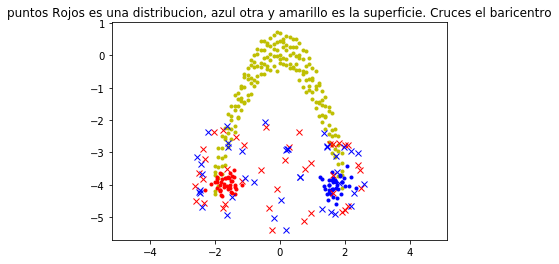

In [36]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

## Aca use y=x como inicial, beta=landa*0.5, lag_nuevo<=(1+1/landa)*lag_viejo, niter=300000, learningrate0=1,beta=1 inicial, landamax=10e4, landa0=10

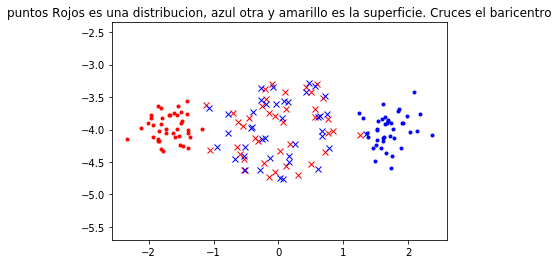

In [12]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

## Aca use y=x como inicial, beta=landa*0.4, lag_nuevo<=(1+0.01/landa)*lag_viejo, niter=100000, learningrate0=1,beta=1 inicial, landamax=10e4, landa0=10

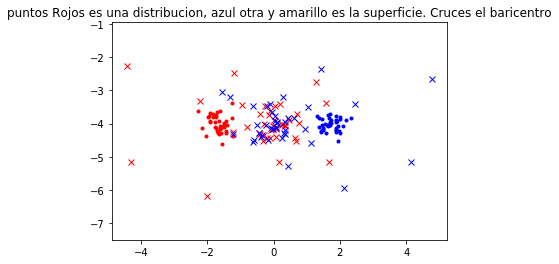

In [554]:
#plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:puntos,0],y[:puntos,1],'x',c='r')
plt.plot(y[puntos:,0],y[puntos:,1],'x',c='b')
plt.axis('equal')
plt.title('puntos Rojos es una distribucion, azul otra y amarillo es la superficie. Cruces el baricentro')
plt.show()

Probando un poco que ande le algoritmo y descienda bien la parte de la f

[ 0.00078002  0.          0.00079181  0.         -0.00079181  0.
 -0.00078002  0.        ]


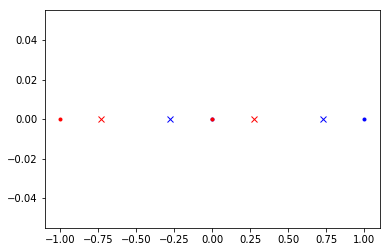

In [118]:
yy=np.array([[1,0],[0,0],[0,0],[-1,0]])
yy_init=yy
zz=np.array([1,1,2,2]).T

for i in range(500):
    C2=armar_C_categorico(zz)
    grad_matrix2=grad_matrix_y(yy)
    f_grad=fgrad(yy,grad_matrix2,C2)
    if (i==0): print(f_grad)

    yy=yy.flatten()-f_grad
    yy=yy.reshape(-1,2)

plt.plot(yy_init[:2,0],yy_init[:2,1],'.',c='b')
plt.plot(yy_init[2:,0],yy_init[2:,1],'.',c='r')
plt.plot(yy[:2,0],yy[:2,1],'x',c='b')
plt.plot(yy[2:,0],yy[2:,1],'x',c='r')
plt.show()
    

# Ignorar, son pruebas de aca para abajo

esto dio con 10.000 iteraciones

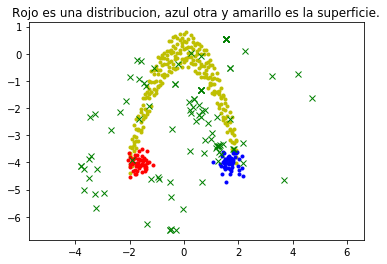

In [67]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:,0],y[:,1],'x',c='g')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie.')
plt.show()

Esto dio con 500 iteraciones, va queriendo...

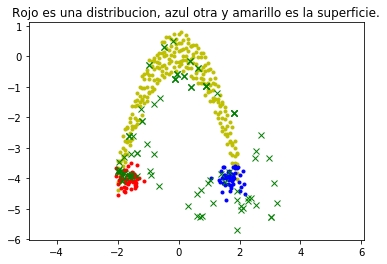

In [64]:
plt.plot(W[:,0],W[:,1],'.',c='y')
plt.plot(x1,x2,'.',c='r')
plt.plot(y1,y2,'.',c='b')
plt.plot(y[:,0],y[:,1],'x',c='g')
plt.axis('equal')
plt.title('Rojo es una distribucion, azul otra y amarillo es la superficie.')
plt.show()

In [68]:
hice10000=y

In [154]:
def kernel_matrix_y(y):
    def fu(i,j):
        return kernel(y[i,:],y[j,:])
    f=np.vectorize(fu)
    return np.fromfunction(f,(y.shape[0],y.shape[0]),dtype=int)  
    
    
def grad_matrix_y(y):
    def fu2(i,j,d):
        return kernel_grad(y[i,:],y[j,:])[d]
    f2=np.vectorize(fu2)
    return np.fromfunction(f2,(y.shape[0],y.shape[0],dimension),dtype=int)  